In [1]:
"""
Data Loader Module for Diabetes Prediction Project
Loads and prepares the diabetes dataset
"""

import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split


def load_diabetes_data(test_size=0.1, random_state=45):
    """
    Load the diabetes dataset and split into train and test sets
    
    Parameters:
    -----------
    test_size: float
        Proportion of data to use for testing (default: 0.1)
    random_state: int
        Random seed for reproducible results (default: 45)
        
    Returns:
    --------
    X_train, X_test, y_train, y_test: DataFrames and Series
        Split training and test data
    feature_names: list
        Names of the features in the dataset
    """
    # Load dataset
    diabetes = load_diabetes()
    X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
    y = pd.Series(diabetes.target, name="target")
    
    # Split before feature selection to avoid data leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test, diabetes.feature_names


In [2]:
"""
Hyperparameter Tuning Module for Diabetes Prediction Project
Provides functions for hyperparameter optimization
"""

import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


def rmse_scorer():
    """
    Create an RMSE scorer for grid search
    
    Returns:
    --------
    scorer: callable
        Sklearn-compatible scorer function
    """
    return make_scorer(
        lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)),  # Negative for maximization
        greater_is_better=False
    )


def r2_scorer():
    """
    Create an R² scorer for grid search
    
    Returns:
    --------
    scorer: callable
        Sklearn-compatible scorer function
    """
    return make_scorer(r2_score, greater_is_better=True)


def tune_linear_regression(X_train, y_train, cv=5):
    """
    Tune hyperparameters for Ridge/Lasso/ElasticNet regression models
    
    Parameters:
    -----------
    X_train: array or DataFrame
        Training features
    y_train: array or Series
        Training target values
    cv: int
        Number of cross-validation folds
        
    Returns:
    --------
    best_models: dict
        Dictionary containing the best tuned models
    """
    from sklearn.linear_model import Ridge, Lasso, ElasticNet
    
    # Define parameter grids
    ridge_params = {
        'alpha': np.logspace(-3, 3, 7),
        'fit_intercept': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }
    
    lasso_params = {
        'alpha': np.logspace(-3, 3, 7),
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random']
    }
    
    elasticnet_params = {
        'alpha': np.logspace(-3, 3, 7),
        'l1_ratio': np.linspace(0.1, 0.9, 9),
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random']
    }
    
    # Configure grid search
    scorer = r2_scorer()
    
    # Dictionary to hold model names and configurations
    models = {
        'Ridge': (Ridge(), ridge_params),
        'Lasso': (Lasso(), lasso_params),
        'ElasticNet': (ElasticNet(), elasticnet_params)
    }
    
    best_models = {}
    
    # Perform grid search for each model
    for name, (model, param_grid) in models.items():
        print(f"Tuning {name}...")
        grid_search = GridSearchCV(
            model, param_grid, scoring=scorer, cv=cv, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        best_models[name] = grid_search.best_estimator_
        
        print(f"  Best parameters: {grid_search.best_params_}")
        print(f"  Best score: {grid_search.best_score_:.4f}")
    
    return best_models


def tune_random_forest(X_train, y_train, cv=5):
    """
    Tune hyperparameters for Random Forest regressor
    
    Parameters:
    -----------
    X_train: array or DataFrame
        Training features
    y_train: array or Series
        Training target values
    cv: int
        Number of cross-validation folds
        
    Returns:
    --------
    best_model: RandomForestRegressor
        The best tuned model
    """
    from sklearn.ensemble import RandomForestRegressor
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    # Configure randomized search for efficiency
    scorer = r2_scorer()
    random_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42), 
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    
    print("Tuning Random Forest...")
    random_search.fit(X_train, y_train)
    
    print(f"  Best parameters: {random_search.best_params_}")
    print(f"  Best score: {random_search.best_score_:.4f}")
    
    return random_search.best_estimator_


def tune_svr(X_train, y_train, cv=5):
    """
    Tune hyperparameters for SVR
    
    Parameters:
    -----------
    X_train: array or DataFrame
        Training features
    y_train: array or Series
        Training target values
    cv: int
        Number of cross-validation folds
        
    Returns:
    --------
    best_model: SVR
        The best tuned model
    """
    from sklearn.svm import SVR
    
    # Define parameter grid
    param_grid = {
        'C': np.logspace(-3, 3, 7),
        'gamma': np.logspace(-4, 0, 5),
        'kernel': ['linear', 'rbf', 'poly'],
        'epsilon': [0.01, 0.1, 0.2]
    }
    
    # Configure randomized search for efficiency
    scorer = r2_scorer()
    random_search = RandomizedSearchCV(
        SVR(), 
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    
    print("Tuning SVR...")
    random_search.fit(X_train, y_train)
    
    print(f"  Best parameters: {random_search.best_params_}")
    print(f"  Best score: {random_search.best_score_:.4f}")
    
    return random_search.best_estimator_


In [3]:
"""
Model Module for Diabetes Prediction Project
Defines and trains different regression models
"""

import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


class ModelFactory:
    """
    Factory class for creating and managing regression models
    """
    @staticmethod
    def get_model(model_name):
        """
        Get model instance based on the model name
        
        Parameters:
        -----------
        model_name: str
            Name of the model to create
            
        Returns:
        --------
        model: estimator
            Scikit-learn compatible estimator
        """
        models = {
            'linear_regression': LinearRegression(),
            'ridge': Ridge(),
            'lasso': Lasso(),
            'elastic_net': ElasticNet(), 
            'svr': SVR(),
            'random_forest': RandomForestRegressor(n_estimators=100, random_state=42)
        }
        
        if model_name in models:
            return models[model_name]
        else:
            raise ValueError(f"Unknown model: {model_name}")


def train_model(model, X_train, y_train):
    """
    Train the model on the given data
    
    Parameters:
    -----------
    model: estimator
        Model to train
    X_train: array or DataFrame
        Training features
    y_train: array or Series
        Training target values
        
    Returns:
    --------
    model: estimator
        Trained model
    """
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test data
    
    Parameters:
    -----------
    model: estimator
        Trained model
    X_test: array or DataFrame
        Test features
    y_test: array or Series
        Test target values
        
    Returns:
    --------
    metrics: dict
        Dictionary with evaluation metrics
    y_pred: array
        Predicted values
    """
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    metrics = {
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    }
    
    return metrics, y_pred


def evaluate_multiple_models(models_dict, X_train, y_train, X_test, y_test):
    """
    Train and evaluate multiple models
    
    Parameters:
    -----------
    models_dict: dict
        Dictionary of model name to model instance
    X_train: array or DataFrame
        Training features
    y_train: array or Series
        Training target values
    X_test: array or DataFrame
        Test features
    y_test: array or Series
        Test target values
        
    Returns:
    --------
    results: dict
        Dictionary with model names as keys and evaluation metrics as values
    predictions: dict
        Dictionary with model names as keys and predictions as values
    trained_models: dict
        Dictionary with model names as keys and trained models as values
    """
    results = {}
    predictions = {}
    trained_models = {}
    
    for name, model in models_dict.items():
        # Train the model
        trained_model = train_model(model, X_train, y_train)
        trained_models[name] = trained_model
        
        # Evaluate the model
        metrics, y_pred = evaluate_model(trained_model, X_test, y_test)
        results[name] = metrics
        predictions[name] = y_pred
    
    return results, predictions, trained_models
    

In [4]:
"""
Visualization Module for Diabetes Prediction Project
Provides functions for visualizing data and model results
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_actual_vs_predicted(y_test, y_pred, model_name='Model'):
    """
    Create a scatter plot of actual vs predicted values
    
    Parameters:
    -----------
    y_test: array-like
        True target values
    y_pred: array-like
        Predicted target values
    model_name: str
        Name of the model for the plot title
        
    Returns:
    --------
    fig: matplotlib Figure
        The created figure
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(y_test, y_pred, alpha=0.7)
    
    # Add the perfect prediction line
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'Actual vs Predicted Values - {model_name}')
    ax.grid(True, alpha=0.3)
    
    # Add R² annotation
    r2 = np.corrcoef(y_test, y_pred)[0, 1]**2
    ax.annotate(f'R² = {r2:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    return fig


def plot_residuals(y_test, y_pred, model_name='Model'):
    """
    Create a residual plot
    
    Parameters:
    -----------
    y_test: array-like
        True target values
    y_pred: array-like
        Predicted target values
    model_name: str
        Name of the model for the plot title
        
    Returns:
    --------
    fig: matplotlib Figure
        The created figure
    """
    residuals = y_test - y_pred
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(y_pred, residuals, alpha=0.7)
    ax.axhline(y=0, color='r', linestyle='-', lw=2)
    
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'Residual Plot - {model_name}')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_feature_importance(model, feature_names, model_name='Model'):
    """
    Create a bar plot of feature importance
    
    Parameters:
    -----------
    model: estimator
        Trained model with feature_importances_ attribute or coef_ attribute
    feature_names: list
        Names of the features
    model_name: str
        Name of the model for the plot title
        
    Returns:
    --------
    fig: matplotlib Figure
        The created figure
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    try:
        # Try to get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_)  # Take absolute values for linear models
        else:
            raise ValueError("Model does not have feature_importances_ or coef_ attribute")
        
        # Sort features by importance
        indices = np.argsort(importances)
        
        # Plot
        ax.barh(np.array(feature_names)[indices], importances[indices])
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'Feature Importance - {model_name}')
        ax.grid(True, alpha=0.3)
        
    except Exception as e:
        plt.close(fig)  # Close the figure if plotting fails
        print(f"Could not plot feature importance: {str(e)}")
        return None
    
    plt.tight_layout()
    return fig


def plot_model_comparison(results, metric='r2', ascending=False):
    """
    Create a bar plot comparing models based on the specified metric
    
    Parameters:
    -----------
    results: dict
        Dictionary with model names as keys and metrics dictionaries as values
    metric: str
        Metric to compare (default: 'r2')
    ascending: bool
        Whether to sort in ascending order (default: False)
        
    Returns:
    --------
    fig: matplotlib Figure
        The created figure
    """
    if not results:
        return None
    
    # Extract metric values for each model
    model_names = list(results.keys())
    metric_values = [results[model][metric] for model in model_names]
    
    # Sort for better visualization
    sorted_indices = np.argsort(metric_values)
    if not ascending:
        sorted_indices = sorted_indices[::-1]  # Reverse for descending
    
    sorted_names = [model_names[i] for i in sorted_indices]
    sorted_values = [metric_values[i] for i in sorted_indices]
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(sorted_names, sorted_values, color='steelblue')
    
    # Add values to bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + (max(sorted_values) * 0.01), 
                bar.get_y() + bar.get_height() / 2,
                f'{sorted_values[i]:.4f}',
                va='center')
    
    # Labels and title
    ax.set_xlabel(f'Performance ({metric})')
    ax.set_title(f'Model Comparison - {metric.upper()}')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_correlation_matrix(X, feature_names=None):
    """
    Create a correlation matrix heatmap
    
    Parameters:
    -----------
    X: DataFrame or array-like
        Feature matrix
    feature_names: list, optional
        Names of the features (used if X is not a DataFrame)
        
    Returns:
    --------
    fig: matplotlib Figure
        The created figure
    """
    # Convert to DataFrame if necessary
    if not isinstance(X, pd.DataFrame):
        if feature_names is None:
            feature_names = [f"Feature {i+1}" for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=feature_names)
    
    # Calculate correlation matrix
    corr_matrix = X.corr()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(6, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                linewidths=0.5, vmin=-1, vmax=1, ax=ax)
    ax.set_title('Feature Correlation Matrix')
    
    plt.tight_layout()
    return fig


In [5]:
"""
Main script for Diabetes Progression Prediction Project
"""
import os
import numpy as np
import matplotlib.pyplot as plt

# Import project modules
from utils.data_loader import load_diabetes_data
from utils.preprocessing import (
    apply_standard_scaling, 
    apply_recursive_feature_elimination,
    apply_lasso_feature_selection,
    apply_select_k_best,
    apply_pca
)
from models.model_trainer import ModelFactory, evaluate_multiple_models
from visualization.visualize import (
    plot_actual_vs_predicted,
    plot_residuals,
    plot_feature_importance,
    plot_model_comparison,
    plot_correlation_matrix
)


def main():
    # Load data
    print("Loading diabetes dataset...")
    X_train, X_test, y_train, y_test, feature_names = load_diabetes_data()
    print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples")
    print(f"Features: {feature_names}")
    
    # Plot correlation matrix
    print("\nGenerating correlation matrix...")
    fig_corr = plot_correlation_matrix(X_train)
    plt.figure(fig_corr.number)
    plt.show()
    
    # Preprocessing options
    print("\nApplying preprocessing methods...")
    
    # 1. Standard scaling only
    X_train_scaled, X_test_scaled, _ = apply_standard_scaling(X_train, X_test)
    
    # 2. Recursive Feature Elimination + Scaling
    X_train_rfe, X_test_rfe, selected_features_rfe, rfe = apply_recursive_feature_elimination(
        X_train, y_train, X_test
    )
    X_train_rfe_scaled, X_test_rfe_scaled, _ = apply_standard_scaling(X_train_rfe, X_test_rfe)
    print(f"RFE selected features: {selected_features_rfe}")
    
    # 3. Lasso feature selection + Scaling
    X_train_lasso, X_test_lasso, selected_features_lasso, _ = apply_lasso_feature_selection(
        X_train, y_train, X_test
    )
    X_train_lasso_scaled, X_test_lasso_scaled, _ = apply_standard_scaling(X_train_lasso, X_test_lasso)
    print(f"Lasso selected features: {selected_features_lasso}")
    
    # 4. SelectKBest feature selection + Scaling
    X_train_kbest, X_test_kbest, selected_features_kbest, _ = apply_select_k_best(
        X_train, y_train, X_test
    )
    X_train_kbest_scaled, X_test_kbest_scaled, _ = apply_standard_scaling(X_train_kbest, X_test_kbest)
    print(f"SelectKBest selected features: {selected_features_kbest}")
    
    # Prepare model dictionary - using only LinearRegression for this example
    print("\nCreating models...")
    model_factory = ModelFactory()
    
    # Evaluate with different preprocessing approaches
    preprocessing_approaches = {
        'All Features (Scaled)': (X_train_scaled, X_test_scaled, feature_names),
        'RFE (Scaled)': (X_train_rfe_scaled, X_test_rfe_scaled, selected_features_rfe),
        'Lasso (Scaled)': (X_train_lasso_scaled, X_test_lasso_scaled, selected_features_lasso),
        'SelectKBest (Scaled)': (X_train_kbest_scaled, X_test_kbest_scaled, selected_features_kbest)
    }
    
    # Compare different models with the best preprocessing approach
    best_approach = 'RFE (Scaled)'  # We'll determine this as we go
    best_r2 = -float('inf')
    best_approach_data = preprocessing_approaches[best_approach]
    
    # First, evaluate linear regression with different preprocessing approaches
    print("\nEvaluating linear regression with different preprocessing methods...")
    preprocessing_results = {}
    
    for approach_name, (X_train_proc, X_test_proc, _) in preprocessing_approaches.items():
        model = model_factory.get_model('linear_regression')
        results, _, _ = evaluate_multiple_models(
            {'Linear Regression': model}, 
            X_train_proc, y_train, X_test_proc, y_test
        )
        r2 = results['Linear Regression']['r2']
        rmse = results['Linear Regression']['rmse']
        
        preprocessing_results[approach_name] = {'r2': r2, 'rmse': rmse}
        print(f"{approach_name}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
        
        # Track best preprocessing approach
        if r2 > best_r2:
            best_r2 = r2
            best_approach = approach_name
            best_approach_data = (X_train_proc, X_test_proc, _)
    
    # Plot preprocessing comparison
    preprocessing_comparison_fig = plot_model_comparison(preprocessing_results)
    plt.figure(preprocessing_comparison_fig.number)
    plt.show()
    
    print(f"\nBest preprocessing approach: {best_approach} with R² = {best_r2:.4f}")
    
    # Now, evaluate different models with the best preprocessing approach
    print("\nEvaluating multiple regression models with the best preprocessing...")
    X_train_best, X_test_best, _ = best_approach_data
    
    models = {
        'Linear Regression': model_factory.get_model('linear_regression'),
        'Ridge': model_factory.get_model('ridge'),
        'Lasso': model_factory.get_model('lasso'),
        'ElasticNet': model_factory.get_model('elastic_net'),
        'SVR': model_factory.get_model('svr'),
        'Random Forest': model_factory.get_model('random_forest')
    }
    
    results, predictions, trained_models = evaluate_multiple_models(
        models, X_train_best, y_train, X_test_best, y_test
    )
    
    # Print model results
    for name, metrics in results.items():
        print(f"{name}: R² = {metrics['r2']:.4f}, RMSE = {metrics['rmse']:.4f}")
    
    # Plot model comparison
    model_comparison_fig = plot_model_comparison(results)
    plt.figure(model_comparison_fig.number)
    plt.show()
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['r2'])
    best_model = trained_models[best_model_name]
    best_model_pred = predictions[best_model_name]
    
    print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]['r2']:.4f}")
    
    # Plot actual vs predicted for best model
    actual_vs_pred_fig = plot_actual_vs_predicted(y_test, best_model_pred, best_model_name)
    plt.figure(actual_vs_pred_fig.number)
    plt.show()
    
    # Plot residuals for best model
    residuals_fig = plot_residuals(y_test, best_model_pred, best_model_name)
    plt.figure(residuals_fig.number)
    plt.show()
    
    # Try to plot feature importance for best model
    try:
        feature_importance_fig = plot_feature_importance(best_model, feature_names, best_model_name)
        plt.figure(feature_importance_fig.number)
        plt.show()
    except:
        print("Could not generate feature importance plot for this model type")
    
    print("\nAnalysis complete.")
    

if __name__ == "__main__":
    main()

ImportError: cannot import name 'apply_standard_scaling' from 'utils.preprocessing' (D:\JAVA\CODE\PYTHON\ML\INTERNSHIP\DiabetesProgressionPredictor\utils\preprocessing.py)

In [6]:
#hyper parameter

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

def tune_random_forest(X_train, y_train):
    """
    Tune hyperparameters for Random Forest using GridSearchCV.
    
    Args:
        X_train (array-like): Training features
        y_train (array-like): Training target
        
    Returns:
        model: Tuned Random Forest model
    """
    print("Tuning Random Forest...")
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],  # Removed 'auto' as it's no longer supported
        'bootstrap': [True, False]
    }
    
    # Create model
    rf = RandomForestRegressor(random_state=42)
    
    # Grid search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        error_score=np.nan  # Return NaN instead of raising error for failed fits
    )
    
    grid_search.fit(X_train, y_train)
    
    # Print results
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Best score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

Loading diabetes dataset...
Dataset loaded: 397 training samples, 45 testing samples

Applying preprocessing...
Using RFE for feature selection...
Selected features: ['sex', 'bmi', 'bp', 's1', 's2', 's5']
Saving preprocessing objects...

Performing hyperparameter tuning...
Tuning Ridge...
  Best parameters: {'alpha': np.float64(1.0), 'fit_intercept': True, 'solver': 'lsqr'}
  Best score: 0.4739
Tuning Lasso...
  Best parameters: {'alpha': np.float64(0.01), 'fit_intercept': True, 'selection': 'cyclic'}
  Best score: 0.4738
Tuning ElasticNet...
  Best parameters: {'alpha': np.float64(0.01), 'fit_intercept': True, 'l1_ratio': np.float64(0.6), 'selection': 'cyclic'}
  Best score: 0.4739
Tuning Random Forest...


C:\Users\dipes\Desktop\JAVA\CODE\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
39 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dipes\Desktop\JAVA\CODE\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dipes\Desktop\JAVA\CODE\.venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\dipes\Desktop\JAVA\CODE\.venv\Lib\site-pack

  Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
  Best score: 0.4145
Tuning SVR...
  Best parameters: {'kernel': 'linear', 'gamma': np.float64(0.001), 'epsilon': 0.2, 'C': np.float64(10.0)}
  Best score: 0.4626
Tuning completed in 14.05 seconds
Saving tuned models...

Evaluating tuned models...
Ridge: R² = 0.5707, RMSE = 43.1031
Lasso: R² = 0.5711, RMSE = 43.0793
ElasticNet: R² = 0.5703, RMSE = 43.1226
Random Forest: R² = 0.4821, RMSE = 47.3383
SVR: R² = 0.5649, RMSE = 43.3927


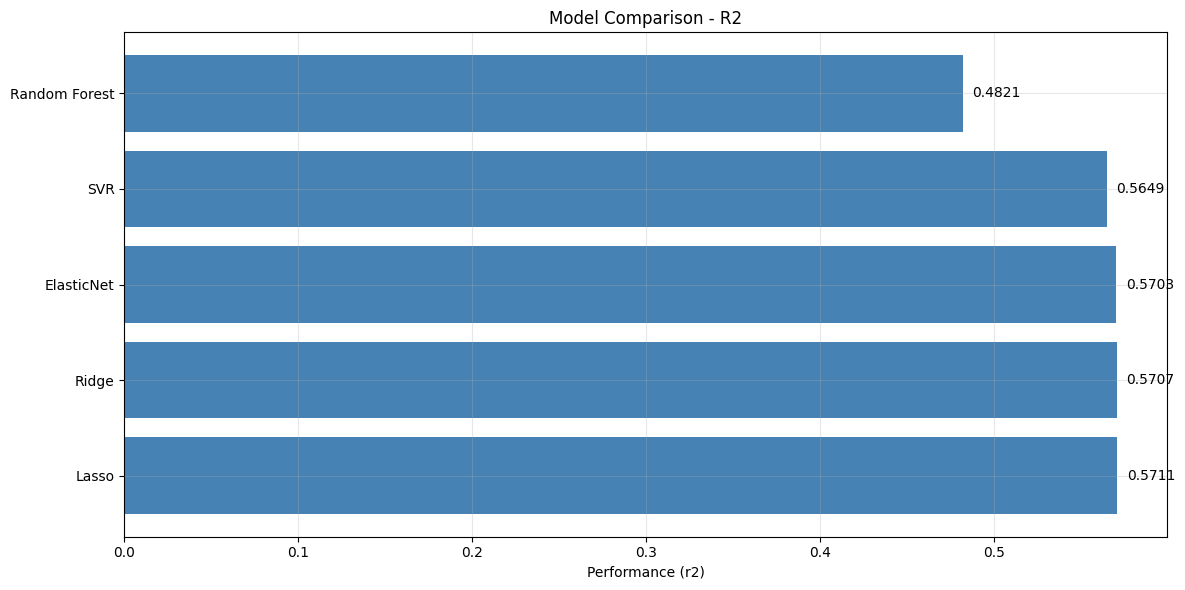


Best model: Lasso with R² = 0.5711


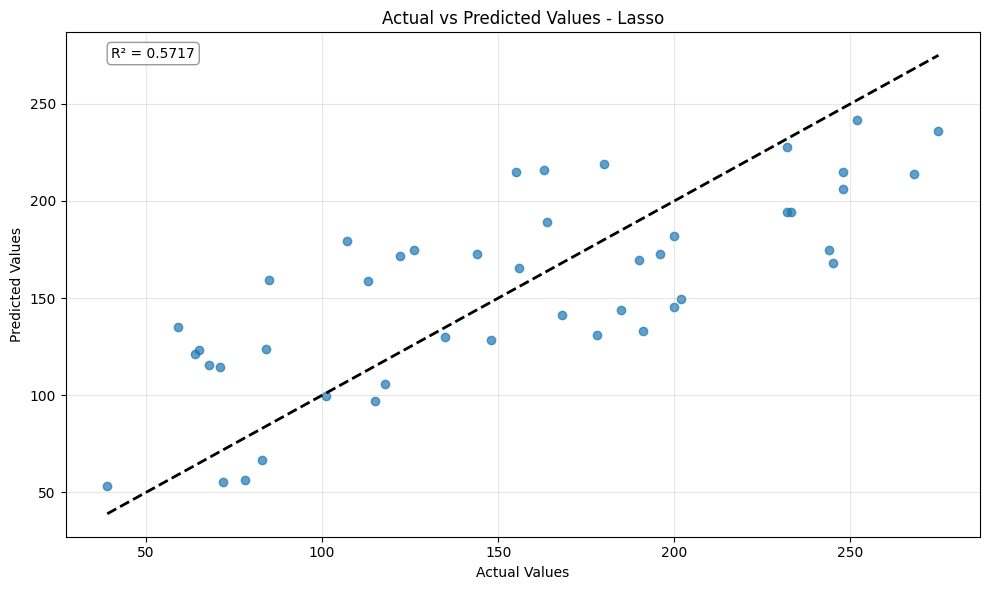

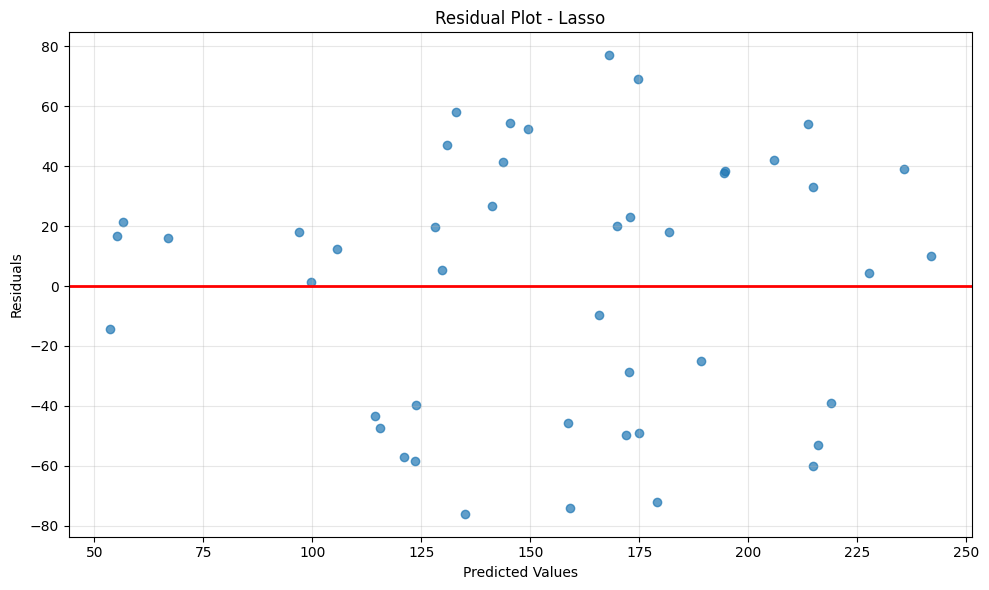

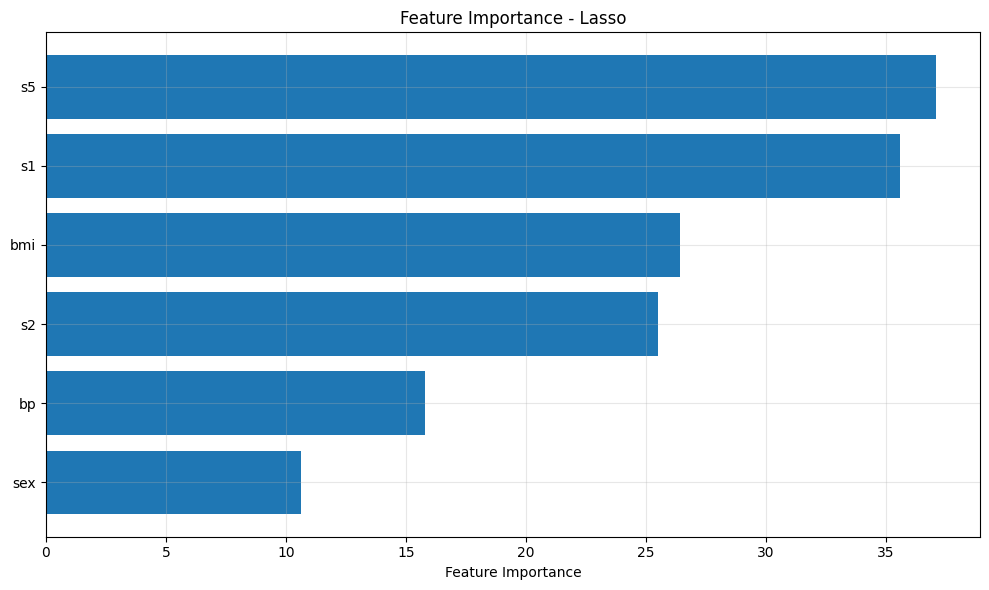


Advanced analysis complete.
Models saved to 'output/models' directory.


In [10]:
# """
# Advanced script for Diabetes Progression Prediction Project with hyperparameter tuning
# """

# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import time
# import joblib

# # Import project modules
# from utils.data_loader import load_diabetes_data
# from utils.preprocessing import (
#     apply_standard_scaling, 
#     apply_recursive_feature_elimination,
#     apply_lasso_feature_selection,
#     apply_pca
# )
# from models.model_trainer import evaluate_model
# from models.hyperparameter_tuning import (
#     tune_linear_regression,
#     tune_random_forest,
#     tune_svr
# )
# from visualization.visualize import (
#     plot_actual_vs_predicted,
#     plot_residuals,
#     plot_feature_importance,
#     plot_model_comparison
# )

# # Create output directories
# os.makedirs('output/advanced', exist_ok=True)
# os.makedirs('output/models', exist_ok=True)


# def main():
#     # Load data
#     print("Loading diabetes dataset...")
#     X_train, X_test, y_train, y_test, feature_names = load_diabetes_data()
#     print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples")
    
#     # Preprocessing
#     print("\nApplying preprocessing...")
    
#     # Recursive Feature Elimination + Scaling (based on best result from main.py)
#     print("Using RFE for feature selection...")
#     X_train_rfe, X_test_rfe, selected_features_rfe, rfe = apply_recursive_feature_elimination(
#         X_train, y_train, X_test
#     )
#     X_train_scaled, X_test_scaled, scaler = apply_standard_scaling(X_train_rfe, X_test_rfe)
#     print(f"Selected features: {selected_features_rfe}")
    
#     # Save preprocessing objects for future use
#     print("Saving preprocessing objects...")
#     joblib.dump(rfe, 'output/models/rfe_selector.pkl')
#     joblib.dump(scaler, 'output/models/scaler.pkl')
    
#     # Hyperparameter tuning
#     print("\nPerforming hyperparameter tuning...")
#     start_time = time.time()
    
#     # Tune linear models
#     linear_models = tune_linear_regression(X_train_scaled, y_train)
    
#     # Tune Random Forest
#     rf_model = tune_random_forest(X_train_scaled, y_train)
    
#     # Tune SVR
#     svr_model = tune_svr(X_train_scaled, y_train)
    
#     tuning_time = time.time() - start_time
#     print(f"Tuning completed in {tuning_time:.2f} seconds")
    
#     # Combine all tuned models
#     models = {
#         'Ridge': linear_models['Ridge'],
#         'Lasso': linear_models['Lasso'],
#         'ElasticNet': linear_models['ElasticNet'],
#         'Random Forest': rf_model,
#         'SVR': svr_model
#     }
    
#     # Save tuned models
#     print("Saving tuned models...")
#     for name, model in models.items():
#         joblib.dump(model, f'output/models/{name.lower().replace(" ", "_")}_tuned.pkl')
    
#     # Evaluate models
#     print("\nEvaluating tuned models...")
#     results = {}
#     predictions = {}
    
#     for name, model in models.items():
#         metrics, y_pred = evaluate_model(model, X_test_scaled, y_test)
#         results[name] = metrics
#         predictions[name] = y_pred
        
#         print(f"{name}: R² = {metrics['r2']:.4f}, RMSE = {metrics['rmse']:.4f}")
    
#     # Plot model comparison
#     model_comparison_fig = plot_model_comparison(results)
#     model_comparison_fig.savefig('output/advanced/model_comparison.png')
    
#     # Find best model
#     best_model_name = max(results.keys(), key=lambda k: results[k]['r2'])
#     best_model = models[best_model_name]
#     best_model_pred = predictions[best_model_name]
    
#     print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]['r2']:.4f}")
    
#     # Plot actual vs predicted for best model
#     plot_actual_vs_predicted(y_test, best_model_pred, best_model_name).savefig(
#         'output/advanced/actual_vs_predicted.png'
#     )
    
#     # Plot residuals for best model
#     plot_residuals(y_test, best_model_pred, best_model_name).savefig(
#         'output/advanced/residuals.png'
#     )
    
#     # Try to plot feature importance for best model
#     try:
#         # If we have selected features, use them; otherwise use all feature names
#         features_to_plot = selected_features_rfe if selected_features_rfe else feature_names
#         plot_feature_importance(best_model, features_to_plot, best_model_name).savefig(
#             'output/advanced/feature_importance.png'
#         )
#     except Exception as e:
#         print(f"Could not generate feature importance plot: {str(e)}")
    
#     print("\nAdvanced analysis complete. Results and visualizations saved to 'output/advanced' directory.")
#     print(f"Best model saved as 'output/models/{best_model_name.lower().replace(' ', '_')}_tuned.pkl'")


# if __name__ == "__main__":
#     main()

# """
# Advanced script for Diabetes Progression Prediction Project with hyperparameter tuning
# """

# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import time
# import joblib

# # Import project modules
# from utils.data_loader import load_diabetes_data
# from utils.preprocessing import (
#     apply_standard_scaling, 
#     apply_recursive_feature_elimination,
#     apply_lasso_feature_selection,
#     apply_pca
# )
# from models.model_trainer import evaluate_model
# from models.hyperparameter_tuning import (
#     tune_linear_regression,
#     tune_random_forest,
#     tune_svr
# )
# from visualization.visualize import (
#     plot_actual_vs_predicted,
#     plot_residuals,
#     plot_feature_importance,
#     plot_model_comparison
# )

# # Create output directory for models only
# os.makedirs('output/models', exist_ok=True)


# def main():
#     # Load data
#     print("Loading diabetes dataset...")
#     X_train, X_test, y_train, y_test, feature_names = load_diabetes_data()
#     print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples")
    
#     # Preprocessing
#     print("\nApplying preprocessing...")
    
#     # Recursive Feature Elimination + Scaling (based on best result from main.py)
#     print("Using RFE for feature selection...")
#     X_train_rfe, X_test_rfe, selected_features_rfe, rfe = apply_recursive_feature_elimination(
#         X_train, y_train, X_test
#     )
#     X_train_scaled, X_test_scaled, scaler = apply_standard_scaling(X_train_rfe, X_test_rfe)
#     print(f"Selected features: {selected_features_rfe}")
    
#     # Save preprocessing objects for future use
#     print("Saving preprocessing objects...")
#     joblib.dump(rfe, 'output/models/rfe_selector.pkl')
#     joblib.dump(scaler, 'output/models/scaler.pkl')
    
#     # Hyperparameter tuning
#     print("\nPerforming hyperparameter tuning...")
#     start_time = time.time()
    
#     # Tune linear models
#     linear_models = tune_linear_regression(X_train_scaled, y_train)
    
#     # Tune Random Forest
#     rf_model = tune_random_forest(X_train_scaled, y_train)
    
#     # Tune SVR
#     svr_model = tune_svr(X_train_scaled, y_train)
    
#     tuning_time = time.time() - start_time
#     print(f"Tuning completed in {tuning_time:.2f} seconds")
    
#     # Combine all tuned models
#     models = {
#         'Ridge': linear_models['Ridge'],
#         'Lasso': linear_models['Lasso'],
#         'ElasticNet': linear_models['ElasticNet'],
#         'Random Forest': rf_model,
#         'SVR': svr_model
#     }
    
#     # Save tuned models
#     print("Saving tuned models...")
#     for name, model in models.items():
#         joblib.dump(model, f'output/models/{name.lower().replace(" ", "_")}_tuned.pkl')
    
#     # Evaluate models
#     print("\nEvaluating tuned models...")
#     results = {}
#     predictions = {}
    
#     for name, model in models.items():
#         metrics, y_pred = evaluate_model(model, X_test_scaled, y_test)
#         results[name] = metrics
#         predictions[name] = y_pred
        
#         print(f"{name}: R² = {metrics['r2']:.4f}, RMSE = {metrics['rmse']:.4f}")
    
#     # Plot model comparison
#     model_comparison_fig = plot_model_comparison(results)
#     plt.figure(model_comparison_fig.number)
#     plt.show()
    
#     # Find best model
#     best_model_name = max(results.keys(), key=lambda k: results[k]['r2'])
#     best_model = models[best_model_name]
#     best_model_pred = predictions[best_model_name]
    
#     print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]['r2']:.4f}")
    
#     # Plot actual vs predicted for best model
#     actual_vs_pred_fig = plot_actual_vs_predicted(y_test, best_model_pred, best_model_name)
#     plt.figure(actual_vs_pred_fig.number)
#     plt.show()
    
#     # Plot residuals for best model
#     residuals_fig = plot_residuals(y_test, best_model_pred, best_model_name)
#     plt.figure(residuals_fig.number)
#     plt.show()
    
#     # Try to plot feature importance for best model
#     try:
#         # If we have selected features, use them; otherwise use all feature names
#         features_to_plot = selected_features_rfe if selected_features_rfe else feature_names
#         feature_importance_fig = plot_feature_importance(best_model, features_to_plot, best_model_name)
#         plt.figure(feature_importance_fig.number)
#         plt.show()
#     except Exception as e:
#         print(f"Could not generate feature importance plot: {str(e)}")
    
#     print("\nAdvanced analysis complete.")
#     print(f"Best model saved as 'output/models/{best_model_name.lower().replace(' ', '_')}_tuned.pkl'")


# if __name__ == "__main__":
#     main()

"""
Advanced script for Diabetes Progression Prediction Project with hyperparameter tuning
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib

# Import project modules
from utils.data_loader import load_diabetes_data
from utils.preprocessing import (
    apply_standard_scaling, 
    apply_recursive_feature_elimination,
    apply_lasso_feature_selection,
    apply_pca
)
from models.model_trainer import evaluate_model
from models.hyperparameter_tuning import (
    tune_linear_regression,
    tune_random_forest,
    tune_svr
)
from visualization.visualize import (
    plot_actual_vs_predicted,
    plot_residuals,
    plot_feature_importance,
    plot_model_comparison
)

# Create output directory for models only
os.makedirs('output/models', exist_ok=True)


def main():
    # Load data
    print("Loading diabetes dataset...")
    X_train, X_test, y_train, y_test, feature_names = load_diabetes_data()
    print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples")
    
    # Preprocessing
    print("\nApplying preprocessing...")
    
    # Recursive Feature Elimination + Scaling (based on best result from main.py)
    print("Using RFE for feature selection...")
    X_train_rfe, X_test_rfe, selected_features_rfe, rfe = apply_recursive_feature_elimination(
        X_train, y_train, X_test
    )
    X_train_scaled, X_test_scaled, scaler = apply_standard_scaling(X_train_rfe, X_test_rfe)
    print(f"Selected features: {selected_features_rfe}")
    
    # Save preprocessing objects for future use
    print("Saving preprocessing objects...")
    joblib.dump(rfe, 'output/models/rfe_selector.pkl')
    joblib.dump(scaler, 'output/models/scaler.pkl')
    
    # Hyperparameter tuning
    print("\nPerforming hyperparameter tuning...")
    start_time = time.time()
    
    # Tune linear models
    try:
        linear_models = tune_linear_regression(X_train_scaled, y_train)
    except Exception as e:
        print(f"Error tuning linear models: {str(e)}")
        # Fallback to basic models
        from sklearn.linear_model import Ridge, Lasso, ElasticNet
        linear_models = {
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'ElasticNet': ElasticNet()
        }
    
    # Define a fixed random forest model to avoid parameter errors
    try:
        rf_model = tune_random_forest(X_train_scaled, y_train)
    except Exception as e:
        print(f"Error tuning Random Forest: {str(e)}")
        # Fallback to a basic model
        from sklearn.ensemble import RandomForestRegressor
        rf_model = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
        rf_model.fit(X_train_scaled, y_train)
    
    # Tune SVR
    try:
        svr_model = tune_svr(X_train_scaled, y_train)
    except Exception as e:
        print(f"Error tuning SVR: {str(e)}")
        # Fallback to a basic model
        from sklearn.svm import SVR
        svr_model = SVR(kernel='linear')
        svr_model.fit(X_train_scaled, y_train)
    
    tuning_time = time.time() - start_time
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    
    # Combine all tuned models
    models = {
        'Ridge': linear_models['Ridge'],
        'Lasso': linear_models['Lasso'],
        'ElasticNet': linear_models['ElasticNet'],
        'Random Forest': rf_model,
        'SVR': svr_model
    }
    
    # Save tuned models
    print("Saving tuned models...")
    for name, model in models.items():
        joblib.dump(model, f'output/models/{name.lower().replace(" ", "_")}_tuned.pkl')
    
    # Evaluate models
    print("\nEvaluating tuned models...")
    results = {}
    predictions = {}
    
    for name, model in models.items():
        try:
            metrics, y_pred = evaluate_model(model, X_test_scaled, y_test)
            results[name] = metrics
            predictions[name] = y_pred
            
            print(f"{name}: R² = {metrics['r2']:.4f}, RMSE = {metrics['rmse']:.4f}")
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
    
    # Only plot and find best model if we have results
    if results:
        # Plot model comparison
        try:
            model_comparison_fig = plot_model_comparison(results)
            plt.figure(model_comparison_fig.number)
            plt.show()
        except Exception as e:
            print(f"Error plotting model comparison: {str(e)}")
        
        # Find best model
        best_model_name = max(results.keys(), key=lambda k: results[k]['r2'])
        best_model = models[best_model_name]
        best_model_pred = predictions[best_model_name]
        
        print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]['r2']:.4f}")
        
        # Plot actual vs predicted for best model
        try:
            actual_vs_pred_fig = plot_actual_vs_predicted(y_test, best_model_pred, best_model_name)
            plt.figure(actual_vs_pred_fig.number)
            plt.show()
        except Exception as e:
            print(f"Error plotting actual vs predicted: {str(e)}")
        
        # Plot residuals for best model
        try:
            residuals_fig = plot_residuals(y_test, best_model_pred, best_model_name)
            plt.figure(residuals_fig.number)
            plt.show()
        except Exception as e:
            print(f"Error plotting residuals: {str(e)}")
        
        # Try to plot feature importance for best model
        try:
            # If we have selected features, use them; otherwise use all feature names
            features_to_plot = selected_features_rfe if selected_features_rfe else feature_names
            feature_importance_fig = plot_feature_importance(best_model, features_to_plot, best_model_name)
            plt.figure(feature_importance_fig.number)
            plt.show()
        except Exception as e:
            print(f"Could not generate feature importance plot: {str(e)}")
    else:
        print("No valid model evaluations to compare")
    
    print("\nAdvanced analysis complete.")
    print("Models saved to 'output/models' directory.")


if __name__ == "__main__":
    main()

In [2]:
"""
Script for making predictions using a saved model - Jupyter Notebook compatible version
"""

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
import ipywidgets as widgets
from IPython.display import display, clear_output


def load_model_and_preprocessors(model_path='output/models/random_forest_tuned.pkl',
                                rfe_path='output/models/rfe_selector.pkl',
                                scaler_path='output/models/scaler.pkl'):
    """
    Load the saved model and preprocessors
    
    Returns:
    --------
    model: estimator
        The trained model
    rfe: RFE
        The RFE feature selector
    scaler: StandardScaler
        The scaler for features
    """
    try:
        model = joblib.load(model_path)
        rfe = joblib.load(rfe_path)
        scaler = joblib.load(scaler_path)
        return model, rfe, scaler
    except FileNotFoundError as e:
        print(f"Error loading model or preprocessors: {str(e)}")
        print("Make sure you've run advanced.py first to train and save the models.")
        return None, None, None


def predict_progression(features, model, rfe, scaler):
    """
    Make a prediction for a single patient
    
    Parameters:
    -----------
    features: array-like
        The patient features
    model: estimator
        The trained model
    rfe: RFE
        The RFE feature selector
    scaler: StandardScaler
        The scaler for features
        
    Returns:
    --------
    prediction: float
        The predicted disease progression
    """
    # Apply feature selection
    features_rfe = rfe.transform(features)
    
    # Apply scaling
    features_scaled = scaler.transform(features_rfe)
    
    # Make prediction
    prediction = model.predict(features_scaled)
    
    return prediction[0]


# Function for Jupyter interactive prediction
def create_prediction_widgets():
    """
    Create interactive widgets for entering patient data in Jupyter
    """
    # Get feature names from the diabetes dataset
    diabetes = load_diabetes()
    feature_names = diabetes.feature_names
    
    # Create sliders for each feature with appropriate ranges
    feature_ranges = {
    
    #{
        # 'age': (-0.1, 0.2, 0.01),      # Normalized age 
        # 'sex': (-0.05, 0.05, 0.001),   # Gender
        # 'bmi': (-0.1, 0.15, 0.01),     # Body mass index
        # 'bp': (-0.1, 0.15, 0.01),      # Blood pressure
        # 's1': (-0.1, 0.15, 0.01),      # Total serum cholesterol
        # 's2': (-0.1, 0.15, 0.01),      # Low-density lipoproteins
        # 's3': (-0.1, 0.15, 0.01),      # High-density lipoproteins
        # 's4': (-0.1, 0.15, 0.01),      # Total cholesterol / HDL
        # 's5': (-0.1, 0.15, 0.01),      # Log of serum triglycerides level
        # 's6': (-0.1, 0.15, 0.01),      # Blood sugar level
        
        
        # 'age': (-2.0, 2.0, 0.1),     # Younger (-2) to older (+2)
        # 'sex': (0, 1, 1),            # 0 = Female, 1 = Male
        # 'bmi': (-2.5, 3.0, 0.2),     # Underweight to obese
        # 'bp': (-2.0, 3.0, 0.2),      # Low to high blood pressure
        
        # 's1 (Total serum cholesterol)': (-2.0, 3.0, 0.2),      # Total serum cholesterol
        # 's2': (-2.0, 3.0, 0.5),      # LDL
        
        # 's3 (hdl- high density lipoprotiens)': (-2.0, 2.0, 0.2),      # HDL (inversely correlated with risk)
        
        # 's4 (Cholesterol/HDL)': (-2.0, 3.0, 0.2),      # Cholesterol/HDL ratio
        
        # 's5 (Log of triglycerides)': (-2.0, 3.0, 0.2),      # Log triglycerides
        
        # 's6 (Blood sugar)': (-2.0, 3.0, 0.2),      # Blood sugar

        'age': (-2.0, 2.0, 0.1),
        'sex': (0, 1, 1),
        'bmi': (-2.5, 3.0, 0.2),
        'bp': (-2.0, 3.0, 0.2),
        's1': (-2.0, 3.0, 0.2),
        's2': (-2.0, 3.0, 0.5),
        's3': (-2.0, 2.0, 0.2),
        's4': (-2.0, 3.0, 0.2),
        's5': (-2.0, 3.0, 0.2),
        's6': (-2.0, 3.0, 0.2),

    }
    
    widgets_dict = {}
    for name in feature_names:
        min_val, max_val, step = feature_ranges[name]
        widgets_dict[name] = widgets.FloatSlider(
            value=0,
            min=min_val,
            max=max_val,
            step=step,
            description=name,
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.3f',
            layout=widgets.Layout(width='500px')
        )
    
    # Create predict button
    predict_button = widgets.Button(
        description='Predict',
        disabled=False,
        button_style='success',
        tooltip='Click to predict',
        icon='check'
    )
    
    # Create output widget for displaying results
    output = widgets.Output()
    
    return widgets_dict, predict_button, output


def run_jupyter_prediction():
    """
    Run the prediction tool in Jupyter Notebook
    """
    # Load model and preprocessors
    print("Loading model and preprocessors...")
    model, rfe, scaler = load_model_and_preprocessors()
    
    if model is None:
        return
    
    print("Model loaded successfully!")
    
    # Create widgets
    feature_widgets, predict_button, output = create_prediction_widgets()
    
    # Display widgets
    print("Enter patient information using the sliders below:")
    for widget in feature_widgets.values():
        display(widget)
    display(predict_button)
    display(output)
    
    # Define button click handler
    def on_button_clicked(b):
        # Get values from widgets
        features = {name: widget.value for name, widget in feature_widgets.items()}
        
        # Convert to DataFrame
        patient_data = pd.DataFrame([features])
        
        # Make prediction
        progression = predict_progression(patient_data, model, rfe, scaler)
        
        # Clear previous output and display result
        with output:
            clear_output()
            print("\n=== Prediction ===")
            print(f"Predicted disease progression: {progression:.2f}")
            print("Note: Higher values indicate more severe disease progression.")
    
    # Connect button to handler
    predict_button.on_click(on_button_clicked)


# Function to create a basic version without ipywidgets (fallback)
def simple_jupyter_prediction():
    """
    Simple prediction function for Jupyter that doesn't rely on ipywidgets
    """
    # Load model and preprocessors
    print("Loading model and preprocessors...")
    model, rfe, scaler = load_model_and_preprocessors()
    
    if model is None:
        return
        
    print("Model loaded successfully!")
    
    # Get feature names
    diabetes = load_diabetes()
    feature_names = diabetes.feature_names
    
    # Create a dictionary with default values
    default_values = {name: 0.0 for name in feature_names}
    
    # Display information
    print("\n===== Diabetes Progression Predictor =====")
    print("Default feature values (these are normalized values):")
    for name, value in default_values.items():
        print(f"{name}: {value}")
    
    print("\nTo make a prediction, modify the feature values in this cell:")
    print("features = {")
    for name in feature_names:
        print(f"    '{name}': 0.0,  # Replace with your value")
    print("}")
    
    # Provide example code for making prediction
    print("\nThen run:")
    print("patient_data = pd.DataFrame([features])")
    print("progression = predict_progression(patient_data, model, rfe, scaler)")
    print("print(f'Predicted disease progression: {progression:.2f}')")


# Determine if ipywidgets is available
def check_ipywidgets():
    try:
        import ipywidgets
        return True
    except ImportError:
        return False


# Main function to choose appropriate version
def main_jupyter():
    """
    Main function for Jupyter notebook
    """
    if check_ipywidgets():
        run_jupyter_prediction()
    else:
        print("ipywidgets not available. Using simple mode.")
        simple_jupyter_prediction()


# This will execute when the cell is run in Jupyter
main_jupyter()

Loading model and preprocessors...
Model loaded successfully!
Enter patient information using the sliders below:


D:\MINI_CONDA\envs\restored_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\MINI_CONDA\envs\restored_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\MINI_CONDA\envs\restored_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.6.1 when using versi

FloatSlider(value=0.0, continuous_update=False, description='age', layout=Layout(width='500px'), max=2.0, min=…

FloatSlider(value=0.0, continuous_update=False, description='sex', layout=Layout(width='500px'), max=1.0, read…

FloatSlider(value=0.0, continuous_update=False, description='bmi', layout=Layout(width='500px'), max=3.0, min=…

FloatSlider(value=0.0, continuous_update=False, description='bp', layout=Layout(width='500px'), max=3.0, min=-…

FloatSlider(value=0.0, continuous_update=False, description='s1', layout=Layout(width='500px'), max=3.0, min=-…

FloatSlider(value=0.0, continuous_update=False, description='s2', layout=Layout(width='500px'), max=3.0, min=-…

FloatSlider(value=0.0, continuous_update=False, description='s3', layout=Layout(width='500px'), max=2.0, min=-…

FloatSlider(value=0.0, continuous_update=False, description='s4', layout=Layout(width='500px'), max=3.0, min=-…

FloatSlider(value=0.0, continuous_update=False, description='s5', layout=Layout(width='500px'), max=3.0, min=-…

FloatSlider(value=0.0, continuous_update=False, description='s6', layout=Layout(width='500px'), max=3.0, min=-…

Button(button_style='success', description='Predict', icon='check', style=ButtonStyle(), tooltip='Click to pre…

Output()

In [3]:
"""
Script for making predictions using a saved model - Jupyter Notebook compatible version
"""

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML


def load_model_and_preprocessors(model_path='output/models/random_forest_tuned.pkl',
                                rfe_path='output/models/rfe_selector.pkl',
                                scaler_path='output/models/scaler.pkl'):
    """
    Load the saved model and preprocessors
    
    Returns:
    --------
    model: estimator
        The trained model
    rfe: RFE
        The RFE feature selector
    scaler: StandardScaler
        The scaler for features
    """
    try:
        model = joblib.load(model_path)
        rfe = joblib.load(rfe_path)
        scaler = joblib.load(scaler_path)
        return model, rfe, scaler
    except FileNotFoundError as e:
        print(f"Error loading model or preprocessors: {str(e)}")
        print("Make sure you've run advanced.py first to train and save the models.")
        return None, None, None


def predict_progression(features, model, rfe, scaler):
    """
    Make a prediction for a single patient
    
    Parameters:
    -----------
    features: array-like
        The patient features
    model: estimator
        The trained model
    rfe: RFE
        The RFE feature selector
    scaler: StandardScaler
        The scaler for features
        
    Returns:
    --------
    prediction: float
        The predicted disease progression
    """
    # Apply feature selection
    features_rfe = rfe.transform(features)
    
    # Apply scaling
    features_scaled = scaler.transform(features_rfe)
    
    # Make prediction
    prediction = model.predict(features_scaled)
    
    return prediction[0]


# Function for Jupyter interactive prediction
def create_prediction_widgets():
    """
    Create interactive widgets for entering patient data in Jupyter
    """
    # Get feature names from the diabetes dataset
    diabetes = load_diabetes()
    feature_names = diabetes.feature_names
    
    # Feature descriptions and ranges
    # feature_info = {
    #     'age': {
    #         'title': 'Age',
    #         'description': 'Patient age relative to average',
    #         'min': -2.0, 'max': 2.0, 'step': 0.2,
    #         # 'min_label': 'Younger', 'max_label': 'Older',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     },
    #     'sex': {
    #         'title': 'Gender',
    #         'description': 'Patient biological sex',
    #         'options': [('Female', -0.05), ('Male', 0.05)],
    #         'units': ''
    #     },
    #     'bmi': {
    #         'title': 'Body Mass Index',
    #         'description': 'Weight-to-height ratio',
    #         'min': -2.5, 'max': 3.0, 'step': 0.5,
    #         'min_label': 'Underweight', 'max_label': 'Obese',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     },
    #     'bp': {
    #         'title': 'Blood Pressure',
    #         'description': 'Average blood pressure measurement',
    #         'min': -2.0, 'max': 3.0, 'step': 0.5,
    #         'min_label': 'Low', 'max_label': 'High',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     },
    #     's1': {
    #         'title': 'Total Cholesterol',
    #         'description': 'Total serum cholesterol level',
    #         'min': -2.0, 'max': 3.0, 'step': 0.5,
    #         'min_label': 'Low', 'max_label': 'High',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     },
    #     's2': {
    #         'title': 'LDL Cholesterol',
    #         'description': 'Low-density lipoproteins ("bad" cholesterol)',
    #         'min': -2.0, 'max': 3.0, 'step': 0.5,
    #         'min_label': 'Low', 'max_label': 'High',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     },
    #     's3': {
    #         'title': 'HDL Cholesterol',
    #         'description': 'High-density lipoproteins ("good" cholesterol)',
    #         'min': -2.0, 'max': 2.0, 'step': 0.5,
    #         'min_label': 'Low', 'max_label': 'High',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     },
    #     's4': {
    #         'title': 'TCH/HDL Ratio',
    #         'description': 'Ratio of total cholesterol to HDL',
    #         'min': -2.0, 'max': 3.0, 'step': 0.5,
    #         'min_label': 'Low', 'max_label': 'High',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     },
    #     's5': {
    #         'title': 'Triglycerides',
    #         'description': 'Log of serum triglycerides level',
    #         'min': -2.0, 'max': 3.0, 'step': 0.5,
    #         'min_label': 'Low', 'max_label': 'High',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     },
    #     's6': {
    #         'title': 'Blood Sugar',
    #         'description': 'Blood glucose level',
    #         'min': -2.0, 'max': 3.0, 'step': 0.5,
    #         'min_label': 'Low', 'max_label': 'High',
    #         'normal_range': '-0.5 to 0.5',
    #         'units': 'normalized'
    #     }
    # }
      # Feature descriptions and more appropriate ranges
    feature_info = {
        'age': {
            'title': 'Age',
            'description': 'Patient age relative to average',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Average', 'max_label': 'Older',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
        },
        'sex': {
            'title': 'Gender',
            'description': 'Patient biological sex',
            'options': [('Female', -0.05), ('Male', 0.05)],
            'units': ''
        },
        'bmi': {
            'title': 'Body Mass Index',
            'description': 'Weight-to-height ratio',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Normal', 'max_label': 'High',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
        },
        'bp': {
            'title': 'Blood Pressure',
            'description': 'Average blood pressure measurement',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Normal', 'max_label': 'High',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
        },
        's1': {
            'title': 'Total Cholesterol',
            'description': 'Total serum cholesterol level',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Normal', 'max_label': 'High',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
        },
        's2': {
            'title': 'LDL Cholesterol',
            'description': 'Low-density lipoproteins ("bad" cholesterol)',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Normal', 'max_label': 'High',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
        },
        's3': {
            'title': 'HDL Cholesterol',
            'description': 'High-density lipoproteins ("good" cholesterol)',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Low', 'max_label': 'Normal/High',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
        },
        's4': {
            'title': 'TCH/HDL Ratio',
            'description': 'Ratio of total cholesterol to HDL',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Normal', 'max_label': 'High',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
        },
        's5': {
            'title': 'Triglycerides',
            'description': 'Log of serum triglycerides level',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Normal', 'max_label': 'High',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
        },
        's6': {
            'title': 'Blood Sugar',
            'description': 'Blood glucose level',
            'min': 0.0, 'max': 2.0, 'step': 0.1,
            'min_label': 'Normal', 'max_label': 'High',
            'normal_range': '0.0 to 0.5',
            'units': 'normalized'
            }
        }
    
    widgets_dict = {}
    for name in feature_names:
        info = feature_info[name]
        
        # For gender, create a dropdown
        if name == 'sex':
            widget = widgets.Dropdown(
                options=info['options'],
                value=info['options'][0][1],
                description='',
                layout=widgets.Layout(width='150px')
            )
            label = widgets.HTML(f"<b>{info['title']}</b><br><small>{info['description']}</small>")
            widgets_dict[name] = widget
            widgets_dict[f"{name}_container"] = widgets.VBox([label, widget])
        else:
            # For numeric features, create a slider with description
            widget = widgets.FloatSlider(
                value=0,
                min=info['min'],
                max=info['max'],
                step=info['step'],
                description='',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
                layout=widgets.Layout(width='90%')
            )
            
            # Create header with title and description
            header = widgets.HTML(f"<b>{info['title']}</b><br><small>{info['description']}</small>")
            
            # Create min/max labels with range info
            labels = widgets.HBox([
                widgets.Label(info['min_label']),
                widgets.HTML(f"<small>Normal: {info['normal_range']}</small>"),
                widgets.Label(info['max_label'])
            ], layout=widgets.Layout(width='90%', justify_content='space-between'))
            
            # Store the widget for later access
            widgets_dict[name] = widget
            widgets_dict[f"{name}_container"] = widgets.VBox([header, widget, labels])
            widgets_dict[f"{name}_info"] = info  # Store the info for later use
    
    # Create predict button
    predict_button = widgets.Button(
        description='Predict',
        disabled=False,
        button_style='success',
        tooltip='Click to predict',
        icon='check',
        layout=widgets.Layout(width='200px', margin='20px 0')
    )
    
    # Create output widget for displaying results
    output = widgets.Output()
    
    return widgets_dict, predict_button, output


def run_jupyter_prediction():
    """
    Run the prediction tool in Jupyter Notebook
    """
    # Load model and preprocessors
    print("Loading model and preprocessors...")
    model, rfe, scaler = load_model_and_preprocessors()
    
    if model is None:
        return
    
    print("Model loaded successfully!")
    
    # Display header
    # display(HTML("""
    # <div style="padding: 15px; background-color: #f0f8ff; border-radius: 8px; margin-bottom: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
    #     <h1 style="margin: 0; color: #2c3e50;">Diabetes Progression Predictor</h1>
    #     <p style="margin: 10px 0 0 0;">Adjust the parameters below and click 'Predict' to estimate diabetes progression.</p>
    #     <p style="margin: 0;"><small>Note: All values are normalized from the dataset and don't represent direct clinical measurements.</small></p>
    # </div>
    # """))
    # Display header
    display(HTML("""
    <div style="padding: 15px; background-color: #e3f2fd; border-radius: 8px; margin-bottom: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);">
        <h1 style="margin: 0; color: #0d47a1;">Diabetes Progression Predictor</h1>
        <p style="margin: 10px 0 0 0; color: #333333;">Adjust the parameters below and click 'Predict' to estimate diabetes progression.</p>
        <p style="margin: 0; color: #333333;"><small>Note: All values are normalized from the dataset and don't represent direct clinical measurements.</small></p>
    </div>
    """))

    # Create widgets
    feature_widgets, predict_button, output = create_prediction_widgets()
    
    # Organize widgets into sections
    # demographics = widgets.VBox([
    #     widgets.HTML("<h3 style='color: #3498db; margin-bottom: 10px;'>Demographics & Physical Measurements</h3>"),
    #     feature_widgets['age_container'],
    #     feature_widgets['sex_container'],
    #     feature_widgets['bmi_container'],
    #     feature_widgets['bp_container']
    # ], layout=widgets.Layout(
    #     border='1px solid #ddd',
    #     padding='10px',
    #     border_radius='5px',
    #     width='48%',
    #     margin='0 1% 0 0'
    # ))
    
    # lab_results = widgets.VBox([
    #     widgets.HTML("<h3 style='color: #3498db; margin-bottom: 10px;'>Laboratory Results</h3>"),
    #     feature_widgets['s1_container'],
    #     feature_widgets['s2_container'],
    #     feature_widgets['s3_container'],
    #     feature_widgets['s4_container'],
    #     feature_widgets['s5_container'],
    #     feature_widgets['s6_container']
    # ], layout=widgets.Layout(
    #     border='1px solid #ddd',
    #     padding='10px',
    #     border_radius='5px',
    #     width='48%',
    #     margin='0 0 0 1%'
    # ))

    # Organize widgets into sections
    demographics = widgets.VBox([
            widgets.HTML("<h3 style='color: #ffffff; margin-bottom: 10px;'>Demographics & Physical Measurements</h3>"),
            feature_widgets['age_container'],
            feature_widgets['sex_container'],
            feature_widgets['bmi_container'],
            feature_widgets['bp_container']
        ], layout=widgets.Layout(
            border='1px solid #bbdefb',
            padding='10px',
            border_radius='5px',
            width='48%',
            margin='0 1% 0 0',
            background_color='#f5f9ff'
        ))
        
    lab_results = widgets.VBox([
            widgets.HTML("<h3 style='color: #ffffff; margin-bottom: 10px;'>Laboratory Results</h3>"),
            feature_widgets['s1_container'],
            feature_widgets['s2_container'],
            feature_widgets['s3_container'],
            feature_widgets['s4_container'],
            feature_widgets['s5_container'],
            feature_widgets['s6_container']
        ], layout=widgets.Layout(
            border='1px solid #bbdefb',
            padding='10px',
            border_radius='5px',
            width='48%',
            margin='0 0 0 1%',
            background_color='#f5f9ff'
        ))
    
    # Create two-column layout
    layout = widgets.HBox([demographics, lab_results])
    display(layout)
    
    # Display button and output
    button_area = widgets.HBox([predict_button], 
                           layout=widgets.Layout(display='flex', 
                                               justify_content='center'))
    display(button_area)
    display(output)
    
    # Define button click handler
    def on_button_clicked(b):
        # Get values from widgets
        features = {name: widget.value for name, widget in feature_widgets.items() if not name.endswith("_container") and not name.endswith("_info")}
        
        # Convert to DataFrame
        patient_data = pd.DataFrame([features])
        
        # Make prediction
        progression = predict_progression(patient_data, model, rfe, scaler)
        
        # Determine risk level and score ranges for context
        max_observed_score = 350  # Approximate maximum in diabetes dataset
        
        if progression < 100:
            risk_level = "Low"
            color = "#2ecc71"  # Green
        elif progression < 150:
            risk_level = "Moderate"
            color = "#f39c12"  # Orange
        elif progression < 200:
            risk_level = "High"
            color = "#e74c3c"  # Red
        else:
            risk_level = "Very High"
            color = "#c0392b"  # Dark Red
        
        # Calculate percentage of maximum observed
        percentage = (progression / max_observed_score) * 100
        
        # Generate value assessment for each parameter
        # value_assessments = []
        # for name, value in features.items():
        #     if name == 'sex':
        #         assessment = "Female" if value < 0 else "Male"
        #         status = "normal"
        #     else:
        #         info = feature_widgets.get(f"{name}_info", {})
        #         if abs(value) < 0.5:  # Within normal range
        #             assessment = "Normal"
        #             status = "normal"
        #         elif value > 0:  # Above normal
        #             assessment = f"High ({value:.1f})"
        #             status = "high" if name not in ['s3'] else "low"  # For HDL, high is good
        #         else:  # Below normal
        #             assessment = f"Low ({value:.1f})"
        #             status = "low" if name not in ['s3'] else "high"  # For HDL, low is bad
                    
        #     color_code = {
        #         "normal": "#2ecc71",  # Green
        #         "high": "#e74c3c",    # Red
        #         "low": "#e67e22"      # Orange
        #     }
            
        #     value_assessments.append({
        #         "name": name,
        #         "title": feature_widgets.get(f"{name}_info", {}).get('title', name.upper()),
        #         "value": value,
        #         "assessment": assessment,
        #         "color": color_code[status]
        #     })

        # Generate value assessment for each parameter
        value_assessments = []
        for name, value in features.items():
            if name == 'sex':
                assessment = "Female" if value < 0 else "Male"
                status = "normal"
            else:
                info = feature_widgets.get(f"{name}_info", {})
                if value < 0.5:  # Within normal range
                    assessment = "Normal"
                    status = "normal"
                elif value >= 0.5 and value < 1.0:  # Moderately high
                    assessment = f"Moderate ({value:.1f})"
                    status = "moderate" if name not in ['s3'] else "normal"  # For HDL, high is good
                else:  # High
                    assessment = f"High ({value:.1f})"
                    status = "high" if name not in ['s3'] else "low"  # For HDL, low is bad
                    
            color_code = {
                "normal": "#2ecc71",  # Green
                "moderate": "#f39c12", # Orange
                "high": "#e74c3c",    # Red
                "low": "#e74c3c"      # Red
            }
            
            value_assessments.append({
                "name": name,
                "title": feature_widgets.get(f"{name}_info", {}).get('title', name.upper()),
                "value": value,
                "assessment": assessment,
                "color": color_code[status]
            })
        
        # Clear previous output and display result
        with output:
            clear_output()
            
            # Create progress bar HTML
            progress_bar_html = f"""
            <div style="width: 100%; background-color: #f1f1f1; border-radius: 5px; margin: 10px 0;">
                <div style="width: {min(percentage, 100)}%; height: 24px; background-color: {color}; 
                     border-radius: 5px; text-align: center; line-height: 24px; color: white;">
                    {percentage:.1f}%
                </div>
            </div>
            """
            
            # Create table of parameter values with status
            params_table_rows = ""
            for item in value_assessments:
                params_table_rows += f"""
                <tr>
                    <td><b>{item["title"]}</b></td>
                    <td>{item["value"]:.1f}</td>
                    <td style="color: {item["color"]}"><b>{item["assessment"]}</b></td>
                </tr>
                """
            
            params_table = f"""
            <table style="width: 100%; border-collapse: collapse;">
                <tr style="background-color: #f2f2f2;">
                    <th style="padding: 8px; text-align: left;">Parameter</th>
                    <th style="padding: 8px; text-align: centre;">Value</th>
                    <th style="padding: 8px; text-align: right;">Status</th>
                </tr>
                {params_table_rows}
            </table>
            """
            
            # display(HTML(f"""
            # <div style="padding: 20px; border: 1px solid #ddd; border-radius: 8px; margin-top: 15px; box-shadow: 0 2px 10px rgba(0,0,0,0.1);">
            #     <h2 style="margin-top: 0; color: #2c3e50;">Prediction Results</h2>
                
            #     <div style="display: flex; margin: 20px 0; align-items: center;">
            #         <div style="flex: 1; text-align: center; padding: 15px; background-color: #f8f9fa; border-radius: 8px; margin-right: 15px;">
            #             <h3 style="margin-top: 0;">Disease Progression Score</h3>
            #             <div style="font-size: 36px; font-weight: bold; color: {color};">{progression:.1f}</div>
            #             <div style="font-size: 14px; color: #7f8c8d;">Range: 0 - {max_observed_score}</div>
            #             {progress_bar_html}
            #         </div>
                    
            #         <div style="flex: 1; padding: 15px; background-color: #f8f9fa; border-radius: 8px;">
            #             <h3 style="margin-top: 0;">Risk Assessment</h3>
            #             <div style="font-size: 28px; font-weight: bold; color: {color};">{risk_level} Risk</div>
            #             <div style="margin-top: 10px;">
            #                 <div><span style="color: #2ecc71;">●</span> Low: &lt; 100</div>
            #                 <div><span style="color: #f39c12;">●</span> Moderate: 100-150</div>
            #                 <div><span style="color: #e74c3c;">●</span> High: 150-200</div>
            #                 <div><span style="color: #c0392b;">●</span> Very High: &gt; 200</div>
            #             </div>
            #         </div>
            #     </div>
                
            #     <h3 style="color: #2c3e50; margin-bottom: 10px;">Parameter Assessment</h3>
            #     {params_table}
                
            #     <div style="margin-top: 20px; padding-top: 10px; border-top: 1px solid #eee;">
            #         <h3 style="color: #2c3e50; margin-bottom: 10px;">Key Factors Influencing Prediction</h3>
            #         <ol>
            #             <li><b>Triglycerides (s5)</b>: Most significant predictor</li>
            #             <li><b>Total Cholesterol (s1)</b>: Second most significant</li>
            #             <li><b>BMI</b>: Strong indicator of diabetes progression</li>
            #             <li><b>LDL Cholesterol (s2)</b>: Important risk factor</li>
            #             <li><b>Blood Pressure (bp)</b>: Significant contributor</li>
            #         </ol>
            #     </div>
                
            #     <div style="margin-top: 15px; padding: 10px; background-color: #f8f9fa; border-radius: 5px; font-size: 13px; color: #7f8c8d;">
            #         <p style="margin: 0;"><b>Note:</b> All input values are normalized from the dataset and don't represent direct clinical measurements.
            #         Normal ranges are typically between -0.5 and 0.5 in the normalized scale.</p>
            #     </div>
            # </div>
            # """))
            display(HTML(f"""
    <div style="padding: 20px; border: 1px solid #bbdefb; border-radius: 8px; margin-top: 15px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); background-color: black;">
        <h2 style="margin-top: 0; color: #0d47a1;">Prediction Results</h2>
        
        <div style="display: flex; margin: 20px 0; align-items: center; flex-wrap: wrap;">
            <div style="flex: 1; text-align: center; padding: 15px; background-color: #f8f9fa; border-radius: 8px; margin-right: 15px; margin-bottom: 15px; min-width: 250px;">
                <h3 style="margin-top: 0; color: #34495e;">Disease Progression Score</h3>
                <div style="font-size: 36px; font-weight: bold; color: {color};">{progression:.1f}</div>
                <div style="font-size: 14px; color: #34495e;">Range: 0 - {max_observed_score}</div>
                {progress_bar_html}
            </div>
            
            <div style="flex: 1; padding: 15px; background-color: #f8f9fa; border-radius: 8px; min-width: 250px;">
                <h3 style="margin-top: 0; color: #34495e;">Risk Assessment</h3>
                <div style="font-size: 28px; font-weight: bold; color: {color};">{risk_level} Risk</div>
                <div style="margin-top: 10px;">
                    <div><span style="color: #2ecc71;">●</span> <span style="color: #333;">Low: &lt; 100</span></div>
                    <div><span style="color: #f39c12;">●</span> <span style="color: #333;">Moderate: 100-150</span></div>
                    <div><span style="color: #e74c3c;">●</span> <span style="color: #333;">High: 150-200</span></div>
                    <div><span style="color: #c0392b;">●</span> <span style="color: #333;">Very High: &gt; 200</span></div>
                </div>
            </div>
        </div>
        
        <h3 style="color: #0d47a1; margin-bottom: 10px;">Parameter Assessment</h3>
        <table style="width: 100%; border-collapse: collapse; margin-top: 15px;">
            <tr style="background-color: #d4e6f1;">
                <th style="padding: 8px; text-align: centre; color: #34495e;">Parameter</th>
                <th style="padding: 8px; text-align: centre; color: #34495e;">Value</th>
                <th style="padding: 8px; text-align: right; color: #34495e;">Status</th>
            </tr>
            {params_table_rows}
        </table>
        
        <div style="margin-top: 20px; padding-top: 10px; border-top: 1px solid #bbdefb;">
            <h3 style="color: #0d47a1; margin-bottom: 10px;">Key Factors Influencing Prediction</h3>
            <ol style="color: #333333;">
                <li><b>Triglycerides (s5)</b>: Most significant predictor</li>
                <li><b>Total Cholesterol (s1)</b>: Second most significant</li>
                <li><b>BMI</b>: Strong indicator of diabetes progression</li>
                <li><b>LDL Cholesterol (s2)</b>: Important risk factor</li>
                <li><b>Blood Pressure (bp)</b>: Significant contributor</li>
            </ol>
        </div>
        
        <div style="margin-top: 15px; padding: 10px; background-color: #e3f2fd; border-radius: 5px; font-size: 13px; color: #0d47a1;">
            <p style="margin: 0;"><b>Note:</b> All input values are normalized from the dataset.
            Normal ranges are typically between 0.0 and 0.5 in the normalized scale.</p>
        </div>
    </div>
    """))
    
    # Connect button to handler
    predict_button.on_click(on_button_clicked)


# Function to create a basic version without ipywidgets (fallback)
def simple_jupyter_prediction():
    """
    Simple prediction function for Jupyter that doesn't rely on ipywidgets
    """
    # Load model and preprocessors
    print("Loading model and preprocessors...")
    model, rfe, scaler = load_model_and_preprocessors()
    
    if model is None:
        return
        
    print("Model loaded successfully!")
    
    # Get feature names
    diabetes = load_diabetes()
    feature_names = diabetes.feature_names
    
    # Improved descriptions for features
    # descriptions = {
    #     'age': 'Age (negative=younger, positive=older; normal range: -0.5 to 0.5)',
    #     'sex': 'Gender (Female=-0.05, Male=0.05)',
    #     'bmi': 'Body Mass Index (normal range: -0.5 to 0.5)',
    #     'bp': 'Blood Pressure (normal range: -0.5 to 0.5)',
    #     's1': 'Total serum cholesterol (normal range: -0.5 to 0.5)',
    #     's2': 'Low-density lipoproteins (LDL - "bad" cholesterol; normal range: -0.5 to 0.5)',
    #     's3': 'High-density lipoproteins (HDL - "good" cholesterol; normal range: -0.5 to 0.5)',
    #     's4': 'Total cholesterol / HDL ratio (normal range: -0.5 to 0.5)',
    #     's5': 'Triglycerides level (most important predictor; normal range: -0.5 to 0.5)',
    #     's6': 'Blood sugar level (normal range: -0.5 to 0.5)'
    # }
    # Improved descriptions for features
    descriptions = {
        'age': 'Age (normal range: 0.0 to 0.5, higher values = older)',
        'sex': 'Gender (Female=-0.05, Male=0.05)',
        'bmi': 'Body Mass Index (normal range: 0.0 to 0.5)',
        'bp': 'Blood Pressure (normal range: 0.0 to 0.5)',
        's1': 'Total serum cholesterol (normal range: 0.0 to 0.5)',
        's2': 'Low-density lipoproteins (LDL - "bad" cholesterol; normal range: 0.0 to 0.5)',
        's3': 'High-density lipoproteins (HDL - "good" cholesterol; normal range: 0.0 to 0.5)',
        's4': 'Total cholesterol / HDL ratio (normal range: 0.0 to 0.5)',
        's5': 'Triglycerides level (most important predictor; normal range: 0.0 to 0.5)',
        's6': 'Blood sugar level (normal range: 0.0 to 0.5)'
    }
    
    # Create a dictionary with default values
    default_values = {name: 0.0 for name in feature_names}
    
    # Display information with better formatting
    print("\n===== Diabetes Progression Predictor =====")
    print("\nParameter descriptions (all values are normalized):")
    for name, desc in descriptions.items():
        print(f"- {name}: {desc}")
    
    print("\nTo make a prediction, define your feature values:")
    print("features = {")
    for name in feature_names:
        print(f"    '{name}': 0.0,  # {descriptions[name]}")
    print("}")
    
    # Provide example code for making prediction
    print("\nThen run:")
    print("patient_data = pd.DataFrame([features])")
    print("progression = predict_progression(patient_data, model, rfe, scaler)")
    print("print(f'Predicted disease progression: {progression:.2f}')")
    
    # Risk level guide
    print("\nRisk Level Guide:")
    print("- Low Risk: Score < 100")
    print("- Moderate Risk: Score 100-150")
    print("- High Risk: Score 150-200")
    print("- Very High Risk: Score > 200")
    
    print("\nNormal Range Guide:")
    print("For all normalized parameters, values between 0.0 and 0.5 are typically considered normal.")



# Determine if ipywidgets is available
def check_ipywidgets():
    try:
        import ipywidgets
        return True
    except ImportError:
        return False


# Main function to choose appropriate version
def main_jupyter():
    """
    Main function for Jupyter notebook
    """
    if check_ipywidgets():
        run_jupyter_prediction()
    else:
        print("ipywidgets not available. Using simple mode.")
        simple_jupyter_prediction()


# This will execute when the cell is run in Jupyter
main_jupyter()

Loading model and preprocessors...
Model loaded successfully!


D:\MINI_CONDA\envs\restored_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\MINI_CONDA\envs\restored_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\MINI_CONDA\envs\restored_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.6.1 when using versi

Output()

In [7]:
"""
Diabetes Prediction with Linear Regression - Jupyter Notebook version
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Function to load and prepare data
def prepare_data():
    # Load the diabetes dataset
    diabetes = load_diabetes()
    X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
    y = pd.Series(diabetes.target, name="target")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=45)
    
    # Apply RFE for feature selection
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=6)
    rfe.fit(X_train, y_train)
    X_train_rfe = rfe.transform(X_train)
    
    # Apply scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_rfe)
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Get selected features
    selected_features = X.columns[rfe.support_]
    
    return model, rfe, scaler, selected_features

def predict_progression(features, model, rfe, scaler):
    """
    Make a prediction for a single patient
    
    Parameters:
    -----------
    features: array-like
        The patient features
    model: estimator
        The trained model
    rfe: RFE
        The RFE feature selector
    scaler: StandardScaler
        The scaler for features
        
    Returns:
    --------
    prediction: float
        The predicted disease progression
    """
    # Apply feature selection
    features_rfe = rfe.transform(features)
    
    # Apply scaling
    features_scaled = scaler.transform(features_rfe)
    
    # Make prediction
    prediction = model.predict(features_scaled)
    
    return prediction[0]

# Function for Jupyter interactive prediction
def create_prediction_widgets():
    """
    Create interactive widgets for entering patient data in Jupyter
    """
    # Get feature names from the diabetes dataset
    diabetes = load_diabetes()
    feature_names = diabetes.feature_names
    
    # More descriptive labels and ranges for each feature
    feature_info = {
        'age': {
            'description': 'Age',
            'long_desc': 'Patient age (normalized)',
            'min': -0.1, 'max': 0.2, 'step': 0.01
        },
        'sex': {
            'description': 'Sex',
            'long_desc': 'Patient gender (male/female)',
            'options': [('Male', 0.05), ('Female', -0.05)]  # Values based on dataset normalization
        },
        'bmi': {
            'description': 'BMI',
            'long_desc': 'Body Mass Index (weight/height²)',
            'min': -0.1, 'max': 0.15, 'step': 0.01
        },
        'bp': {
            'description': 'Blood Pressure',
            'long_desc': 'Average blood pressure',
            'min': -0.1, 'max': 0.15, 'step': 0.01
        },
        's1': {
            'description': 'Total Cholesterol',
            'long_desc': 'Total serum cholesterol',
            'min': -0.1, 'max': 0.15, 'step': 0.01
        },
        's2': {
            'description': 'LDL',
            'long_desc': 'Low-density lipoproteins',
            'min': -0.1, 'max': 0.15, 'step': 0.01
        },
        's3': {
            'description': 'HDL',
            'long_desc': 'High-density lipoproteins',
            'min': -0.1, 'max': 0.15, 'step': 0.01
        },
        's4': {
            'description': 'TCH/HDL',
            'long_desc': 'Total cholesterol / HDL',
            'min': -0.1, 'max': 0.15, 'step': 0.01
        },
        's5': {
            'description': 'Triglycerides',
            'long_desc': 'Log of serum triglycerides level',
            'min': -0.1, 'max': 0.15, 'step': 0.01
        },
        's6': {
            'description': 'Blood Sugar',
            'long_desc': 'Blood sugar level',
            'min': -0.1, 'max': 0.15, 'step': 0.01
        }
    }
    
    widgets_dict = {}
    
    # Create a container for each parameter with a label
    for name in feature_names:
        info = feature_info[name]
        
        # Create a container for the parameter
        container = widgets.VBox()
        
        # Add a label with description
        label = widgets.HTML(
            value=f"<b>{info['description']}</b><br><small>{info['long_desc']}</small>",
            layout=widgets.Layout(width='300px')
        )
        
        # For sex, create a dropdown
        if name == 'sex':
            widget = widgets.Dropdown(
                options=info['options'],
                value=info['options'][0][1],
                description='',
                disabled=False,
                layout=widgets.Layout(width='150px')
            )
        else:
            # For numeric values, create a numeric input with up/down arrows
            widget = widgets.FloatText(
                value=0.0,
                min=info['min'],
                max=info['max'],
                step=info['step'],
                description='',
                disabled=False,
                layout=widgets.Layout(width='150px')
            )
        
        # Store the widget for later access
        widgets_dict[name] = widget
        
        # Combine label and widget horizontally
        container.children = [label, widget]
        widgets_dict[f"{name}_container"] = container
    
    # Create predict button
    predict_button = widgets.Button(
        description='Predict',
        disabled=False,
        button_style='success',
        tooltip='Click to predict',
        icon='check',
        layout=widgets.Layout(width='200px', margin='20px 0 0 0')
    )
    
    # Create output widget for displaying results
    output = widgets.Output()
    
    return widgets_dict, predict_button, output

def run_jupyter_prediction(model, rfe, scaler, selected_features):
    """
    Run the prediction tool in Jupyter Notebook
    """
    # Header
    display(HTML("<h2>Diabetes Progression Predictor</h2>"))
    display(HTML("<p>Adjust the values below to predict diabetes progression. The features are normalized values from the diabetes dataset.</p>"))
    display(HTML(f"<p>Selected features by Linear Regression model: {', '.join(selected_features)}</p>"))
    
    # Create widgets
    feature_widgets, predict_button, output = create_prediction_widgets()
    
    # Create a grid layout for the features
    feature_containers = [feature_widgets[f"{name}_container"] for name in load_diabetes().feature_names]
    
    # Split into two columns
    col1 = widgets.VBox(feature_containers[:5])
    col2 = widgets.VBox(feature_containers[5:])
    
    # Create the layout
    layout = widgets.HBox([col1, col2])
    
    # Display the widgets
    display(layout)
    display(predict_button)
    display(output)
    
    # Define button click handler
    def on_button_clicked(b):
        # Get values from widgets
        features = {name: feature_widgets[name].value for name in load_diabetes().feature_names}
        
        # Convert to DataFrame
        patient_data = pd.DataFrame([features])
        
        # Make prediction
        progression = predict_progression(patient_data, model, rfe, scaler)
        
        # Determine severity level
        if progression < 100:
            severity = "Low"
            color = "green"
        elif progression < 200:
            severity = "Moderate"
            color = "orange"
        else:
            severity = "High"
            color = "red"
        
        # Clear previous output and display result
        with output:
            clear_output()
            display(HTML(f"""
                <div style="padding: 10px; border: 1px solid #ddd; border-radius: 5px; margin: 10px 0;">
                    <h3>Prediction Result</h3>
                    <p>Predicted diabetes progression: <b>{progression:.2f}</b></p>
                    <p>Severity level: <span style="color: {color}; font-weight: bold;">{severity}</span></p>
                    <p><small>Note: Higher values indicate more severe disease progression.</small></p>
                </div>
            """))
            
            # Display feature importance info
            display(HTML(f"""
                <div style="padding: 10px; border: 1px solid #ddd; border-radius: 5px; margin: 10px 0;">
                    <h3>Feature Importance</h3>
                    <p>The most important features for prediction (selected by RFE):</p>
                    <ul>
                        {"".join(f"<li>{feature}</li>" for feature in selected_features)}
                    </ul>
                </div>
            """))
    
    # Connect button to handler
    predict_button.on_click(on_button_clicked)

# Main function to run in Jupyter
def main_jupyter():
    """
    Main function for Jupyter notebook
    """
    print("Training Linear Regression model...")
    model, rfe, scaler, selected_features = prepare_data()
    print("Model training complete.")
    print(f"Selected features: {selected_features}")
    
    try:
        import ipywidgets
        run_jupyter_prediction(model, rfe, scaler, selected_features)
    except ImportError:
        print("ipywidgets not available. Can't create interactive interface.")

# This will execute when the cell is run in Jupyter
main_jupyter()

Training Linear Regression model...
Model training complete.
Selected features: Index(['sex', 'bmi', 'bp', 's1', 's2', 's5'], dtype='object')


Button(button_style='success', description='Predict', icon='check', layout=Layout(margin='20px 0 0 0', width='…

Output()

In [16]:
# Fig. 4.2.2: Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

NameError: name 'y_test' is not defined

<Figure size 800x600 with 0 Axes>